# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Defining-the-Hypoxia-Response" data-toc-modified-id="Defining-the-Hypoxia-Response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the Hypoxia Response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-Global-HIF-1-response" data-toc-modified-id="Enrichment-Analysis-of-the-Global-HIF-1-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment Analysis of the Global HIF-1 response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analyses-of-the-egl-9-transcriptome" data-toc-modified-id="Enrichment-Analyses-of-the-egl-9-transcriptome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Enrichment Analyses of the <em>egl-9</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-vhl-1-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-vhl-1-transcriptome-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Enrichment Analysis of the <em>vhl-1</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-hif-1--transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-hif-1--transcriptome-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Enrichment Analysis of the <em>hif-1</em>  transcriptome</a></div>

In this notebook, we will isolate the hypoxia response (defined as the set of genes commonly regulated by *egl-9*, *rhy-1* and *vhl-1*), and we will perform enrichment analysis on the hypoxia response. We will also perform enrichment analyses on each mutant transcriptomes, to try to understand how different each transcriptome actually is.

In [1]:
# important stuff:
import os
import pandas as pd

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars
import epistasis as epi

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
# this loads all the labels we need
genvar = gvars.genvars()

tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth_all_adjusted/kallisto/'

thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')
# load beta dataframes:
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

In [4]:
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.mapping[key]
    df['code'] = key
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]
tidy = pd.concat(frames)
tidy.sort_values('sorter', inplace=True)

# Defining the Hypoxia Response

We defined the hypoxia response as the set of genes that change in the same direction in mutants of *egl-9*, *vhl-1* and *rhy-1*. We use `epi.find_overlap` from the `epistasis` module that we wrote. This function finds genes that are statistically significantly altered in common between $n$ genotypes. However, `find_overlap` is direction agnostic. Therefore, I will call it twice: Once with a sliced list of genes that have positive $\beta$s and once with negative $\beta$s. 

In [5]:
hyp_response_pos = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b > 0])
hyp_response_neg = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b < 0])
hyp_response = list(set(hyp_response_neg + hyp_response_pos))

hyp = tidy[(tidy.target_id.isin(hyp_response)) &
           (tidy.code == 'b')
          ].copy().sort_values('qval')
hyp[['target_id', 'ens_gene', 'ext_gene', 'b', 'qval']].to_csv('../output/hypoxia_response.csv', index=False)

# print the number of genes (not isoforms) in the hypoxia response
hyp_response = tidy[tidy.target_id.isin(hyp_response)].ens_gene.unique()
print('There are {0} genes in the predicted hypoxia response'.format(len(hyp_response)))

There are 356 genes in the predicted hypoxia response


# Enrichment Analysis of the Global HIF-1 response

Now that we have found the hypoxia response, we can perform tissue, phenotype and gene ontology enrichment analysis on this gene battery.
Note that we don't show all possibilities. When a particular analysis is not present, it is because the enrichment results were empty.

In [6]:
teaH = tea.enrichment_analysis(hyp_response, tissue_df, show=False)
geaH = tea.enrichment_analysis(hyp_response, go_df, show=False)

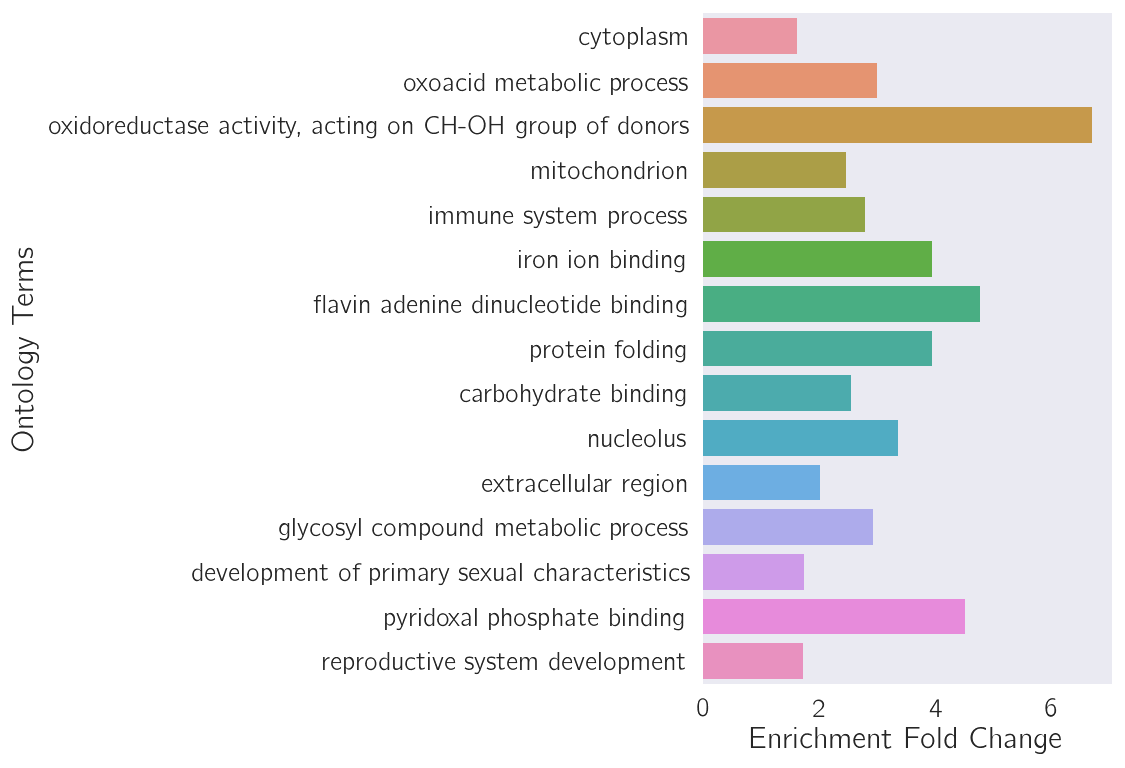

In [20]:
tea.plot_enrichment_results(geaH, analysis='go')
plt.savefig('../output/hypoxia_response_gea.svg', bbox_inches='tight')

In [8]:
teaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
52,cephalic sheath cell WBbt:0008406,6.381646,17,2.663889,0.000093,0.025318
179,uterine seam cell WBbt:0006789,0.884585,5,5.652370,0.000237,0.032321


These enrichment analyses show, as expected, that the HIF-dependent hypoxia response causes important changes in metabolism and physiology relating to oxygen availability. Tissue enrichment shows enrichment in the cephalic sheath cells (strange) but also in the uterine seam cells. Again, no idea what it means, although reports by [Chang and Bargmann](http://www.pnas.org/content/105/20/7321.full) suggest that the somatic gonad plays a special role in modulating behavior during hypoxia.

# Enrichment Analyses of the *egl-9* transcriptome

In [9]:
egl = tidy[(tidy.qval < q) & (tidy.code == 'e')]
teaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), tissue_df, show=False)
peaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), phenotype_df, show=False)
geaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), go_df, show=False)

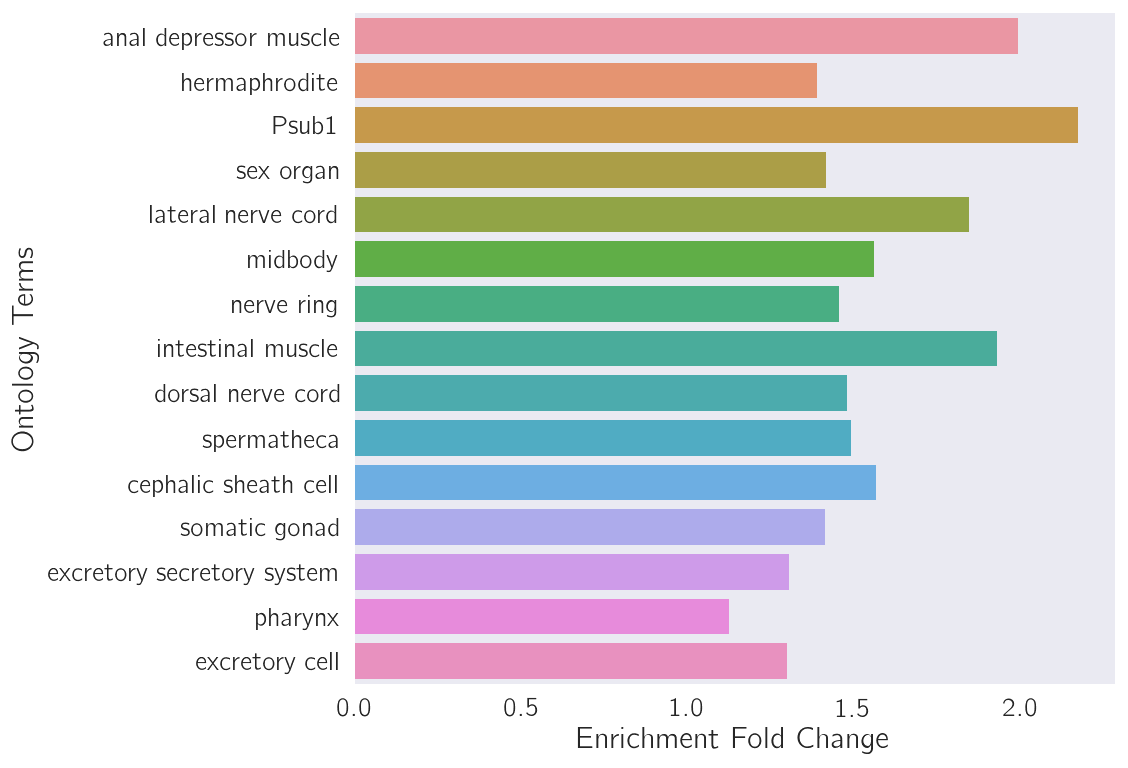

In [10]:
tea.plot_enrichment_results(teaEgl)

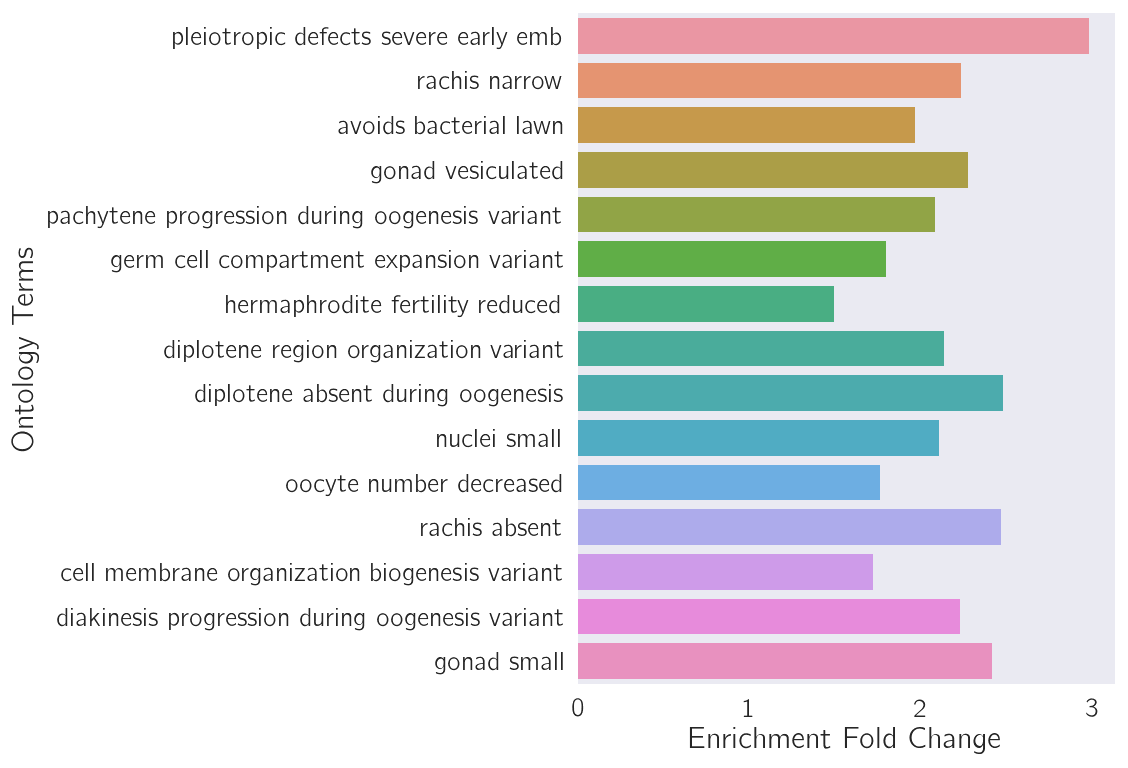

In [11]:
tea.plot_enrichment_results(peaEgl, analysis='phenotype')

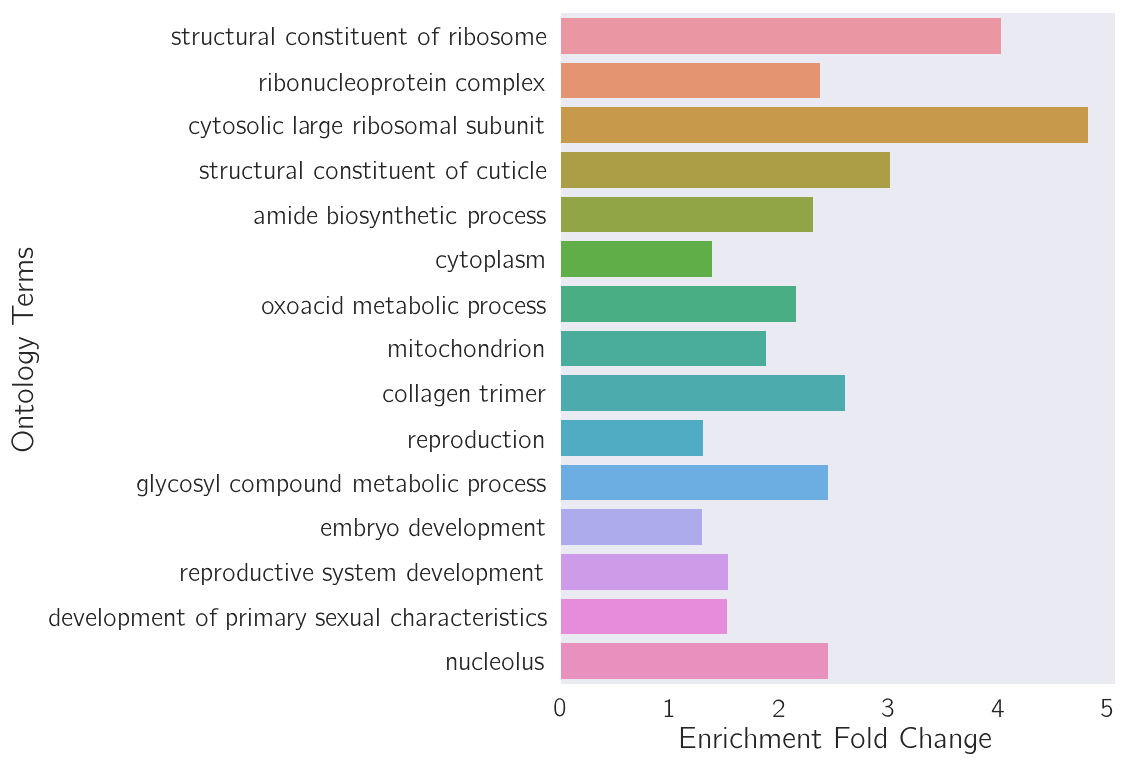

In [12]:
tea.plot_enrichment_results(geaEgl, analysis='go')

# Enrichment Analysis of the *vhl-1* transcriptome

In [13]:
vhl = tidy[(tidy.qval < q) & (tidy.code == 'd')]
teaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), go_df, show=False)

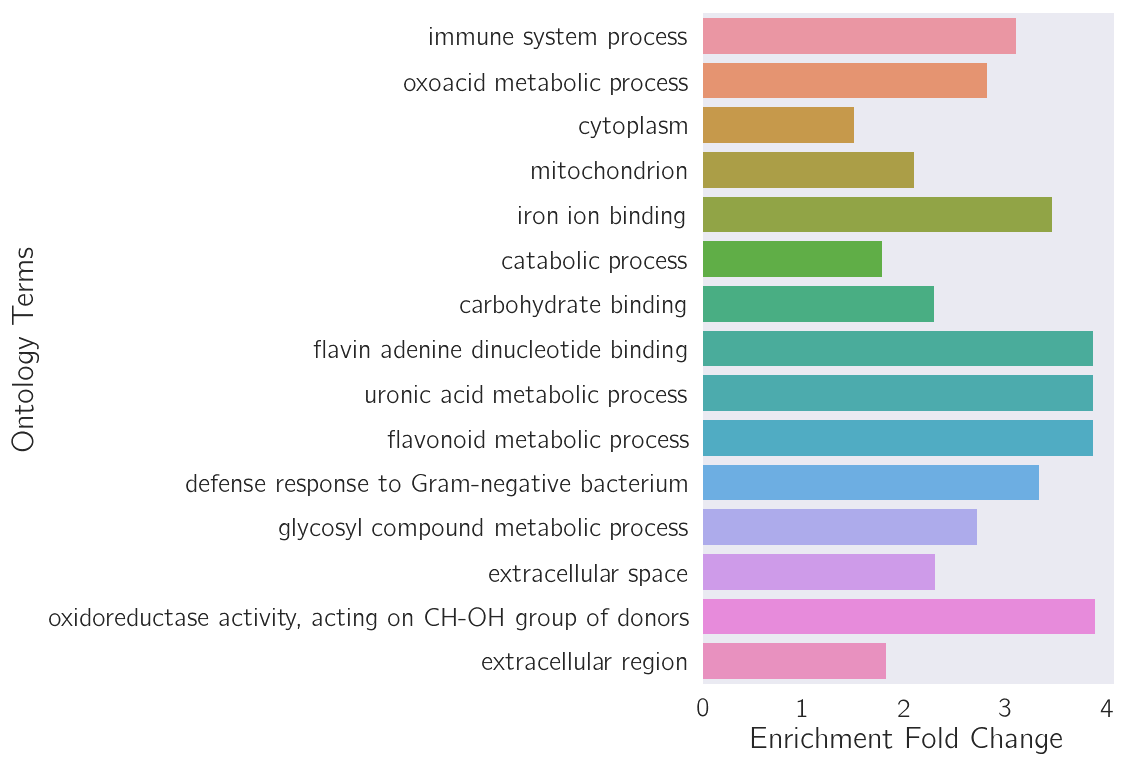

In [14]:
tea.plot_enrichment_results(geaVhl, analysis='go')

In [15]:
teaVhl

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
191,cephalic sheath cell WBbt:0008406,12.644587,32,2.530727,6.114444e-07,0.000167
202,coelomic system WBbt:0005749,37.474715,59,1.574395,2.832798e-04,0.038668
115,anal depressor muscle WBbt:0004292,19.363327,34,1.755897,6.327128e-04,0.046567
124,PVD WBbt:0006831,120.686945,156,1.292600,5.117227e-04,0.046567


# Enrichment Analysis of the *hif-1*  transcriptome

This refers to the genes that are downstream of *hif-1* but not downstream of *egl-9*, *vhl-1* or *rhy-1*.

In [16]:
hif = tidy[(tidy.qval < q) & (tidy.code == 'c')]
teahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), go_df, show=False)

In [17]:
peahif

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
60,pathogen susceptibility increased WBPhenotype:...,6.676770,17,2.546142,0.000135,0.033768
87,dauer constitutive WBPhenotype:0000012,5.458994,14,2.564575,0.000385,0.048069


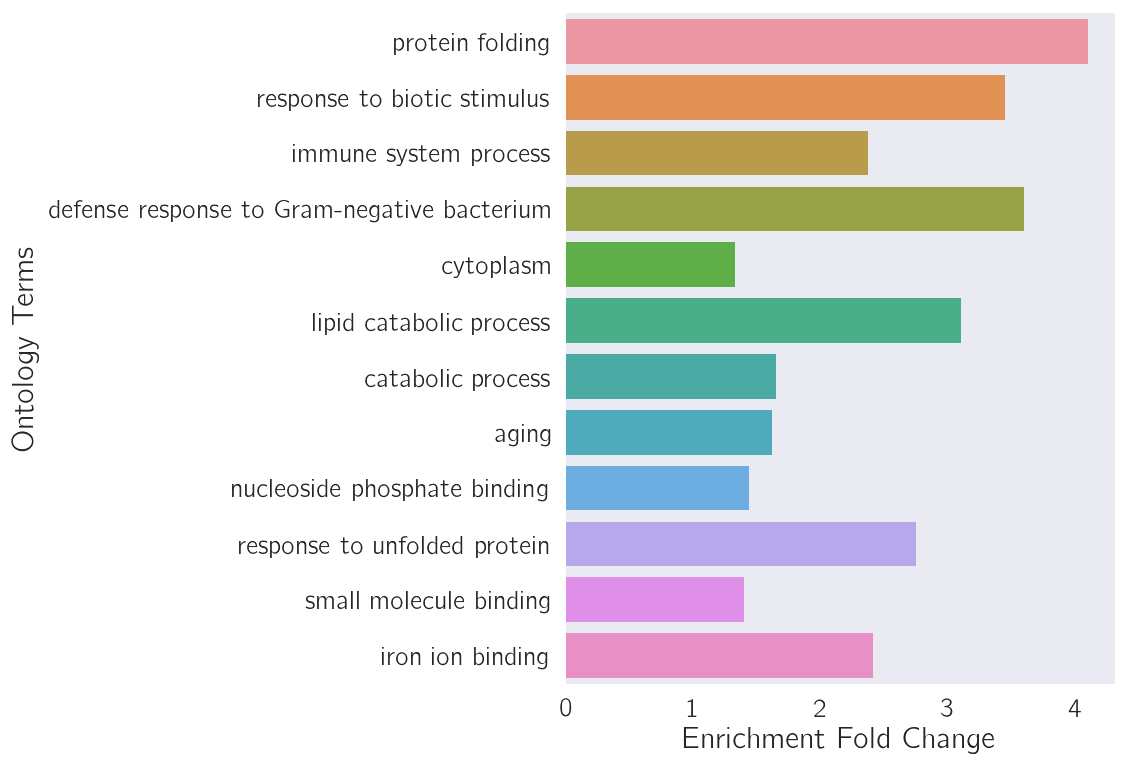

In [18]:
tea.plot_enrichment_results(geahif, analysis='go')

Many terms later, a conclusion is not to be had from enrichment analysis. The transcriptomic results reflect the known involvement of the hypoxic response in the immune response. On the other hand, the transcriptome results from *hif-1* suggest that HIF-1 regulates chaperones tightly even under normoxic conditions.